# Sentiment Analysis of News Headlines

1.   Data Retrieval from BigQuery
2.   Data Pre-Processing
3.   Preliminary Analysis with Visualizations
4.   Model Building



# 1. Data Retrieval
**SQL Query used in BigQuery to retrieve and compile dataset:**

WITH Articles AS (

SELECT

    SOURCEURL,

    MIN(AvgTone) AS AvgTone,

    MIN(GLOBALEVENTID) AS GLOBALEVENTID,

    MIN(SQLDATE) AS SQLDATE,

    MIN(Actor1Code) AS Actor1Code,

    MIN(Actor2Code) AS Actor2Code,

    MIN(EventCode) AS EventCode,

    MIN(ActionGeo_FullName) AS ActionGeo_FullName

 FROM

    `gdelt-bq.gdeltv2.events`

 WHERE

    SQLDATE >= 20231007

    AND SQLDATE <= 20231014

    AND (Actor1Code = 'ISR' OR Actor2Code = 'ISR' OR Actor1Code = 'PSE' OR Actor2Code = 'PSE')

    AND SOURCEURL LIKE '%apnews.com%' // Changed for each domain

  GROUP BY

    SOURCEURL
)

SELECT

    A.SOURCEURL,

    A.AvgTone,

    A.GLOBALEVENTID,

    A.SQLDATE,

    A.Actor1Code,

    A.Actor2Code,

    A.EventCode,

    COUNT(*) AS Popularity

FROM

    Articles A

JOIN

  `gdelt-bq.gdeltv2.events` E

ON

    A.SOURCEURL = E.SOURCEURL

GROUP BY

    A.SOURCEURL, A.AvgTone, A.GLOBALEVENTID, A.SQLDATE, A.Actor1Code, A.Actor2Code, A.EventCode

ORDER BY

    Popularity DESC

LIMIT

    100;

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

import requests
import re

from wordcloud import WordCloud
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Load Dataset
df = pd.read_excel('/content/GDELT Database.xlsx', dtype={'Event Code': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Outlet Name      1092 non-null   object 
 1   Article Link     1092 non-null   object 
 2   Global Event ID  1092 non-null   int64  
 3   SQL Date         1092 non-null   int64  
 4   Actor1 Code      1091 non-null   object 
 5   Actor2 Code      1077 non-null   object 
 6   Event Code       1092 non-null   object 
 7   Popularity       1092 non-null   int64  
 8   Sentiment        1092 non-null   object 
 9   Sentiment Score  1092 non-null   float64
 10  AvgTone          1092 non-null   float64
 11  Article Title    1092 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 102.5+ KB


In [4]:
# Preview
df

,Outlet Name,Article Link,Global Event ID,SQL Date,Actor1 Code,Actor2 Code,Event Code,Popularity,Sentiment,Sentiment Score,AvgTone,Article Title
0,The Jerusalem Post,https://www.jpost.com/middle-east/article-761885,1131572897,20231007,ISR,ISR,171,26,Positive,1.0000,1.489203,Riyadh's trial balloons may be intended to be ...
1,Reuters,https://www.reuters.com/world/nuclear-test-ban...,1131577364,20231007,CHN,CHN,057,47,Positive,0.9426,-4.448743,Russia to reverse nuclear test ban pact ratifi...
2,Reuters,https://www.reuters.com/world/middle-east/sire...,1131604608,20231007,ISRGOV,ISR,036,6,Negative,-0.9997,-3.846154,Israel vows 'mighty vengeance' after surprise ...
3,BBC,https://www.bbc.co.uk/news/world-middle-east-6...,1131607275,20231007,ISR,ISR,073,8,Negative,-0.9997,-5.445545,Israel attack: PM says Israel at war after 250...
4,The Jerusalem Post,https://www.jpost.com/breaking-news/article-76...,1131609326,20231007,ISR,CVL,193,20,Negative,-1.0000,-3.405995,Israel at war: Israel embassy reports 100 Isra...
...,...,...,...,...,...,...,...,...,...,...,...,...
1087,The New York Times,https://www.nytimes.com/2023/11/10/world/europ...,1139382047,20231011,DEU,ISR,124,35,Positive,0.3182,-9.419795,Germany Restricts Pro-Palestinian Protests Ami...
1088,The Washington Post,https://www.washingtonpost.com/politics/2023/1...,1139402992,20231011,ISR,ISR,043,21,Positive,0.9049,-2.507375,NSA officials call out Chinese hackers’ stealt...
1089,Fox News,https://www.foxnews.com/media/hamas-founder-so...,1139599795,20231012,PSE,ISR,173,16,Positive,0.6694,-3.802817,Hamas founder’s son speaks out against terror ...
1090,The Washington Post,https://www.washingtonpost.com/world/2023/11/1...,1139720786,20231013,ISR,JUD,084,11,Negative,-0.9998,-5.505618,Israel’s free speech crackdown: ‘War inside of...


# 2. Pre-Processing
1.   Data Cleaning
2.   Feature Engineering
3.   Data Transformation

**2.1. Data Cleaning**

In [5]:
# Check if there are null values
df.isnull().sum()

Outlet Name         0
Article Link        0
Global Event ID     0
SQL Date            0
Actor1 Code         1
Actor2 Code        15
Event Code          0
Popularity          0
Sentiment           0
Sentiment Score     0
AvgTone             0
Article Title       0
dtype: int64

In [6]:
# Replace null values with N/A and confirm cleanup
df = df.fillna('N/A')
df.isnull().sum()

Outlet Name        0
Article Link       0
Global Event ID    0
SQL Date           0
Actor1 Code        0
Actor2 Code        0
Event Code         0
Popularity         0
Sentiment          0
Sentiment Score    0
AvgTone            0
Article Title      0
dtype: int64

**2.2. Feature Engineering***

New Features: Sentiment Category and Sentiment Score

*  *Sentiment* returns Postive, Negative, or
Neutral

*   *Sentiment Score* returns value between -1 and 1

*DO NOT RUN CODE: This is just an example of how the sentiment analysis was produced to get the sentiment and sentiment score columns already included in the dataset. This code was run seperately in batches due to the amount of processing time it required.

In [7]:
# Perform sentiment analysis on a given text

def analyze_url(url):
    try:
        # Fetch HTML content from the URL
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract text from the HTML content
        text = ' '.join([p.get_text() for p in soup.find_all('p')])

        # Analyze sentiment
        sid = SentimentIntensityAnalyzer()
        sentiment_scores = sid.polarity_scores(text)

        # Classify the sentiment
        if sentiment_scores['compound'] >= 0.05:
            sentiment = 'Positive'
        elif sentiment_scores['compound'] <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return sentiment, sentiment_scores['compound']

    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        return None

# EXAMPLE Usage - I ran my article URLs in batches of 100 in a separate colab for this segment
urls = [ 'https://www.nytimes.com/2023/10/07/world/middleeast/saudi-israel-gaza-war.html',
        'https://www.jpost.com/breaking-news/article-762037' ]
sentiments = []
scores = []
for url in urls:
    sentiment, score = analyze_url(url)
    if sentiment:
        sentiments.append(sentiment)
        scores.append(score)
sentiment_df = pd.DataFrame({'URL': urls, 'Sentiment': sentiments, 'Score': scores})
print(sentiment_df)

# Export to CSV - Necessary to regroup all of the batched articles
sentiment_df.to_csv('SentimentAnalysis.csv', index=False)

from google.colab import files
files.download('SentimentAnalysis.csv')

                                                 URL Sentiment   Score
0  https://www.nytimes.com/2023/10/07/world/middl...  Positive  0.3182
1  https://www.jpost.com/breaking-news/article-76...  Negative -1.0000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**2.3. Data Transformation**


*   Clean Headlines
*   Scale/Standardize Sentiment Score and AvgTone Features



In [8]:
# CLEANING HEADLINES #

headlines = df['Article Title']

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Remove Phrases
remove_phrases = ['The Jerusalem Post','Mondoweiss','Israel News - Haaretz.com','Haaretz.com',
                     'Palestinians - Haaretz.com','Podcasts - Haaretz.com','BBC News','The Washington Post', 'The New York Times']

# Clean and preprocess a single headline
def clean_headline(headline):

    # Remove phrases
    for phrase in remove_phrases:
        headline = headline.replace(phrase, '')

    # Remove everything after the character "|"
    headline = headline.split("|")[0]

    # Remove special characters, numbers, extra whitespaces
    headline = re.sub(r'[^a-zA-Z\s]', '', headline)

    # Make lowercase
    headline = headline.lower()

    # Tokenize headline
    words = word_tokenize(headline)

     # Lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join the cleaned words back into a sentence
    cleaned_headline = ' '.join(words)
    return cleaned_headline

# Apply the cleaning function to all headlines
df['Headline'] = headlines.apply(clean_headline)
df.drop(columns=['Article Title'], inplace=True)

# Display the cleaned headlines
print(df['Headline'])

0                 riyadh trial balloon may intended noted
1       russia reverse nuclear test ban pact ratificat...
2             israel vow mighty vengeance surprise attack
3       israel attack pm say israel war killed attack ...
4       israel war israel embassy report israeli kidna...
                              ...                        
1087    germany restricts propalestinian protest amid ...
1088    nsa official call chinese hacker stealthy offl...
1089    hamas founder son speaks terror group th centu...
1090          israel free speech crackdown war inside war
1091    greta thunberg interrupted climate protest cha...
Name: Headline, Length: 1092, dtype: object


In [9]:
# SCALING / STANDARDIZING SENTIMENT SCORE AND AVGTONE #

# Normalizing numerical features for future analysis
data_columns = ['Sentiment Score', 'AvgTone']
scaler = MinMaxScaler(feature_range=(-1, 1))
df[data_columns] = scaler.fit_transform(df[data_columns])

print(df[['Sentiment Score', 'AvgTone']])

      Sentiment Score   AvgTone
0              1.0000  0.595868
1              0.9426  0.014651
2             -0.9997  0.073633
3             -0.9997 -0.082918
4             -1.0000  0.116717
...               ...       ...
1087           0.3182 -0.471925
1088           0.9049  0.204675
1089           0.6694  0.077875
1090          -0.9998 -0.088798
1091           0.7964  0.294322

[1092 rows x 2 columns]


# 3. Preliminary Analysis with Visualizations


1.   Word Clouds Based on Headlines of Each Outlet
2.   Sentiment Score and AvgTone per Outlet
3.   Overall Distribution of Sentiment



**3.1. Word Clouds Based on Headlines of Each Outlet**

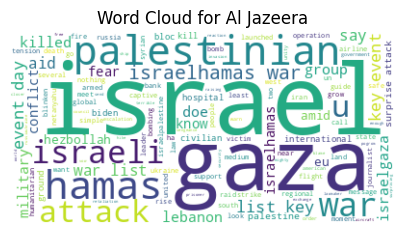

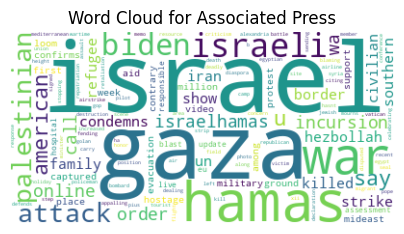

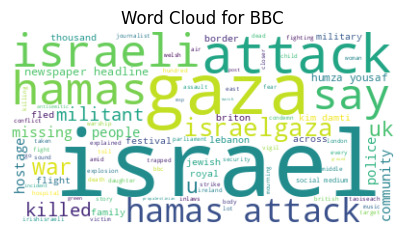

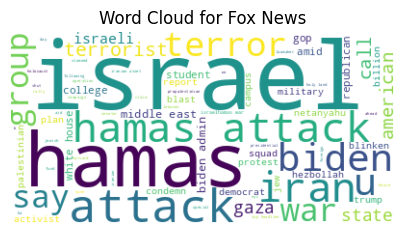

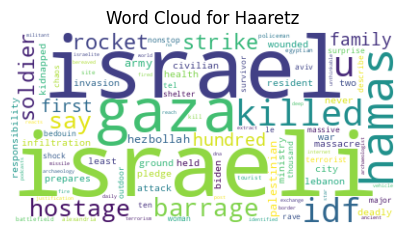

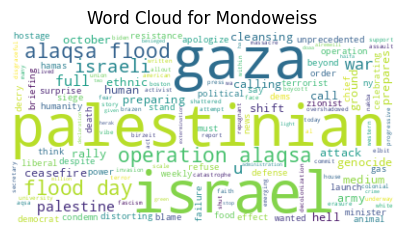

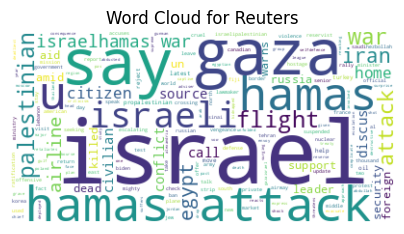

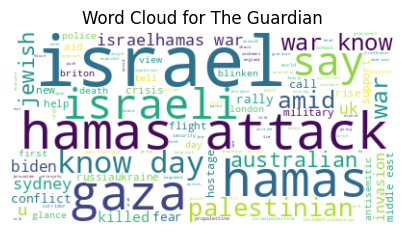

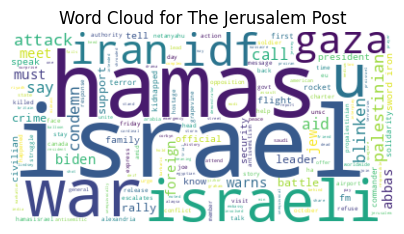

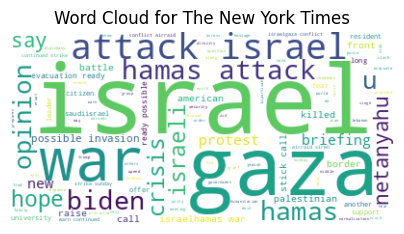

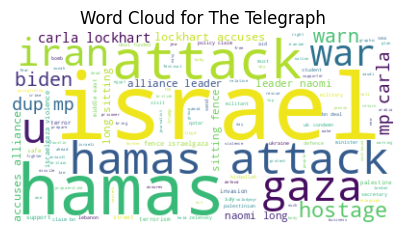

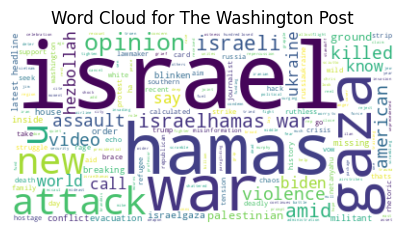

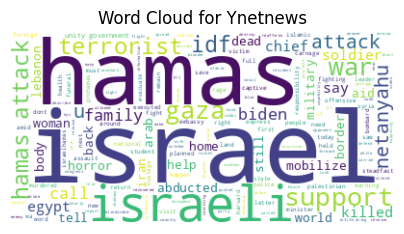

In [10]:
# Group headlines by OutletName
grouped_data = df.groupby('Outlet Name')['Headline'].apply(lambda x: ' '.join(x)).reset_index()

# Generate and display word cloud
def word_cloud(text, title):
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    plt.figure(figsize=(5, 2.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for each outlet
for index, row in grouped_data.iterrows():
    outlet_name = row['Outlet Name']
    headlines_text = row['Headline']
    word_cloud(headlines_text, f'Word Cloud for {outlet_name}')

**3.2. Sentiment Score and AvgTone per Outlet**

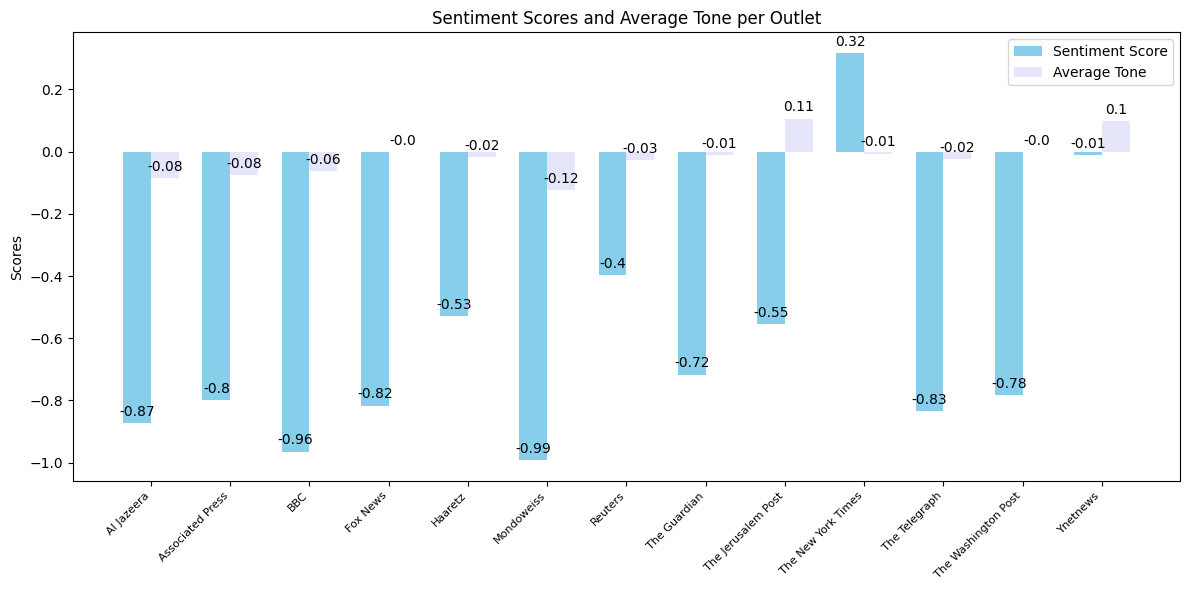

In [11]:
# Group outlet names, calculate mean sentiment and tone
grouped = df.groupby('Outlet Name').agg({'Sentiment Score': 'mean', 'AvgTone': 'mean'}).reset_index()

# Create figure and axis
bar_width = 0.35
fig, axis = plt.subplots(figsize=(12, 6))

# Calculate positions for bars
x = np.arange(len(grouped))
x2 = [pos + bar_width for pos in x]

# Plot
bar1 = axis.bar(x, grouped['Sentiment Score'], width=bar_width, color='skyblue', label='Sentiment Score')
bar2 = axis.bar(x2, grouped['AvgTone'], width=bar_width, color='lavender', label='Average Tone')

# Set x-axis and y-axis labels
axis.set_xticks([pos + bar_width / 2 for pos in x])
axis.set_xticklabels(grouped['Outlet Name'], rotation=45, ha='right', fontsize=8)

axis.set_ylabel('Scores')
axis.set_title('Sentiment Scores and Average Tone per Outlet')

axis.legend()

# Autolabel bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        axis.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show()

**3.3. Overall Distribution of Sentiment**

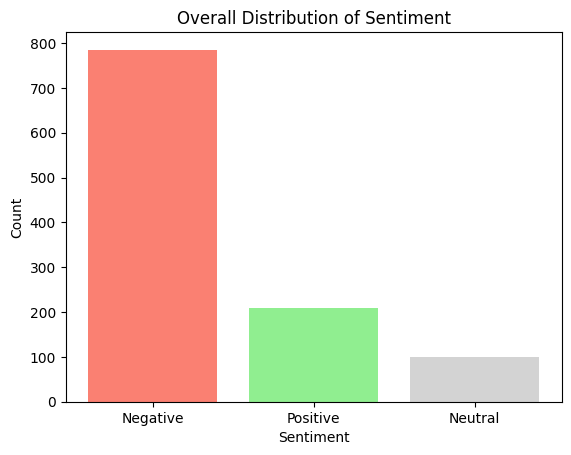

In [12]:
# Count the occurrences of each sentiment label
sentiment_counts = df['Sentiment'].value_counts()

plt.bar(sentiment_counts.index, sentiment_counts.values, color=['salmon', 'lightgreen', 'lightgray'])
plt.title('Overall Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.show()

In [13]:
df['Sentiment'].value_counts()

Negative    785
Positive    208
Neutral      99
Name: Sentiment, dtype: int64

# 4. Classification Model Building


1.   Logistic Regression Model
2.   Exploration of Event Code Applicability



**4.1. Logistic Regression Model**


*   Split data into training and testing sets; initialize and train regression; make predictions; produce evaluation
*   Provide example of performance with new input



In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Headline'], df['Sentiment'], test_size=0.2, random_state=42)

# Apply TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train Logistic Regression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_rep)

Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.99      0.86       165
     Neutral       0.00      0.00      0.00        17
    Positive       0.67      0.05      0.10        37

    accuracy                           0.76       219
   macro avg       0.48      0.35      0.32       219
weighted avg       0.68      0.76      0.67       219



**4.2. Exploration of Event Code Applicability**


*   Goal: identify if specific features of this dataset can be used to build prediction models
  *   Transform data (consolidate event classifications)
  *   Conduct initial analysis with visualizations
  *   Attempt to build models






In [15]:
# Insight into original state of event code labels
event_code_count = df['Event Code'].value_counts()
print(event_code_count)

190     100
051      86
042      84
010      73
020      50
       ... 
161       1
061       1
035       1
0253      1
0332      1
Name: Event Code, Length: 108, dtype: int64


Consult                             192
Make Public Statement               155
Fight                               142
Engage in Diplomatic Cooperation    114
Disapprove                           81
Express Intent to Cooperate          74
Appeal                               72
Assault                              39
Provide Aid                          35
Coerce                               30
Threaten                             29
Yield                                24
Reduce Relations                     20
Engage in Material Cooperation       18
Reject                               18
Protest                              15
Demand                               15
Investigate                           9
Use Unconventional Mass Violence      5
Exhibit Force Posture                 5
Name: event_category, dtype: int64


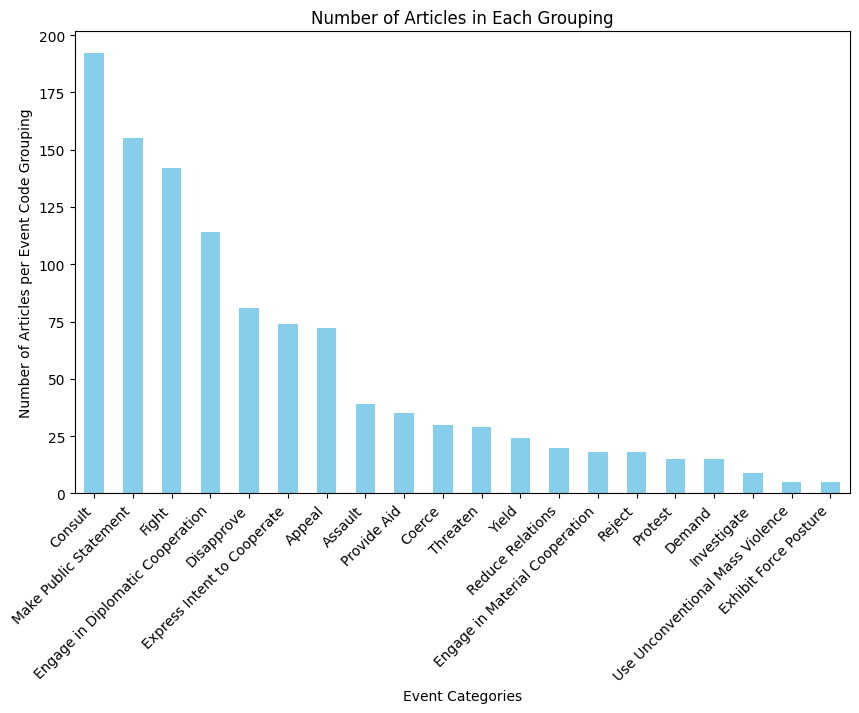

In [16]:
# Categorize events according to GDELT list
def categorize_event(event_code):
    if event_code.startswith('01'):
        return 'Make Public Statement'
    elif event_code.startswith('02'):
        return 'Appeal'
    elif event_code.startswith('03'):
        return 'Express Intent to Cooperate'
    elif event_code.startswith('04'):
        return 'Consult'
    elif event_code.startswith('05'):
        return 'Engage in Diplomatic Cooperation'
    elif event_code.startswith('06'):
        return 'Engage in Material Cooperation'
    elif event_code.startswith('07'):
        return 'Provide Aid'
    elif event_code.startswith('08'):
        return 'Yield'
    elif event_code.startswith('09'):
        return 'Investigate'
    elif event_code.startswith('10'):
        return 'Demand'
    elif event_code.startswith('11'):
        return 'Disapprove'
    elif event_code.startswith('12'):
        return 'Reject'
    elif event_code.startswith('13'):
        return 'Threaten'
    elif event_code.startswith('14'):
        return 'Protest'
    elif event_code.startswith('15'):
        return 'Exhibit Force Posture'
    elif event_code.startswith('16'):
        return 'Reduce Relations'
    elif event_code.startswith('17'):
        return 'Coerce'
    elif event_code.startswith('18'):
        return 'Assault'
    elif event_code.startswith('19'):
        return 'Fight'
    elif event_code.startswith('20'):
        return 'Use Unconventional Mass Violence'
    else:
        return 'Other'

# Create new 'event_category'
df['event_category'] = df['Event Code'].apply(categorize_event)

article_counts = df['event_category'].value_counts()
print(article_counts)

# Visualization depicting number of articles per event code grouping
plt.figure(figsize=(10, 6))
article_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Articles in Each Grouping')
plt.xlabel('Event Categories')
plt.ylabel('Number of Articles per Event Code Grouping')
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
# Identify and display top 3 event categories per outlet
top_events = df.groupby('Outlet Name')['event_category'].value_counts().groupby(level=0).nlargest(3)

for outlet, categories in top_events.groupby(level=0):
    print(f"{outlet}")
    for i, (category, count) in enumerate(categories.items(), start=1):
        # Unpack the nested tuple if present
        if isinstance(category, tuple):
            category = category[-1]
        print(f"  {i}. {category}: {count}")

Al Jazeera
  1. Consult: 16
  2. Make Public Statement: 13
  3. Fight: 12
Associated Press
  1. Fight: 10
  2. Consult: 9
  3. Engage in Diplomatic Cooperation: 5
BBC
  1. Consult: 22
  2. Make Public Statement: 13
  3. Appeal: 11
Fox News
  1. Consult: 22
  2. Make Public Statement: 17
  3. Fight: 14
Haaretz
  1. Fight: 9
  2. Consult: 5
  3. Engage in Diplomatic Cooperation: 4
Mondoweiss
  1. Fight: 7
  2. Engage in Diplomatic Cooperation: 5
  3. Consult: 3
Reuters
  1. Consult: 20
  2. Fight: 15
  3. Make Public Statement: 13
The Guardian
  1. Make Public Statement: 16
  2. Consult: 14
  3. Fight: 12
The Jerusalem Post
  1. Consult: 25
  2. Make Public Statement: 14
  3. Engage in Diplomatic Cooperation: 10
The New York Times
  1. Make Public Statement: 14
  2. Consult: 13
  3. Fight: 13
The Telegraph
  1. Make Public Statement: 19
  2. Engage in Diplomatic Cooperation: 15
  3. Appeal: 9
The Washington Post
  1. Consult: 19
  2. Fight: 18
  3. Engage in Diplomatic Cooperation: 15
Yn

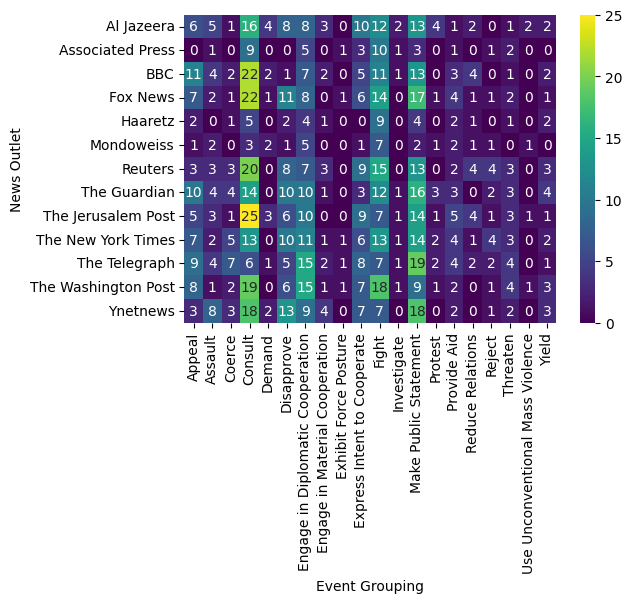

In [18]:
# Visual display of Number of Articles per Outlet per Group via heatmap
event_counts = df.groupby(['Outlet Name', 'event_category']).size().reset_index(name='count')

# Pivot df for easier plotting
pivot_df = event_counts.pivot(index='Outlet Name', columns='event_category', values='count').fillna(0)

plt.figure(figsize=(6,4))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='g')
plt.xlabel('Event Grouping')
plt.ylabel('News Outlet')
plt.show()

In [19]:
# Data Transformation to use in SVC model

df_copy = df.copy()

# Label Encoding - making categorical columns numerical for analysis
encode_columns = ['Outlet Name', 'Actor1 Code', 'Actor2 Code','Sentiment']
label_encoder = LabelEncoder()
for col in encode_columns:
    df_copy[col + '_encoded'] = label_encoder.fit_transform(df_copy[col])

# Drop original columns from df
df_copy.drop(columns=encode_columns, inplace=True)

print(df_copy[['Outlet Name_encoded', 'Actor1 Code_encoded', 'Actor2 Code_encoded', 'Sentiment_encoded']])

      Outlet Name_encoded  Actor1 Code_encoded  Actor2 Code_encoded  \
0                       8                   67                   64   
1                       6                   18                   14   
2                       6                   70                   64   
3                       2                   67                   64   
4                       8                   67                   21   
...                   ...                  ...                  ...   
1087                    9                   27                   64   
1088                   11                   67                   64   
1089                    3                  101                   64   
1090                   11                   67                   73   
1091                    3                   67                   85   

      Sentiment_encoded  
0                     2  
1                     2  
2                     0  
3                     0  
4                

In [20]:
# SVM Model

# Target variable

y = df['event_category']

# Features
X = df_copy[['Sentiment_encoded', 'Sentiment Score', 'Actor1 Code_encoded', 'Actor2 Code_encoded']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM classifier
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

# Print results for SVM
print("SVM Model:")
print("Accuracy:", accuracy_svm)
print("Classification Report:\n", classification_rep_svm)

SVM Model:
Accuracy: 0.1780821917808219
Classification Report:
                                   precision    recall  f1-score   support

                          Appeal       0.00      0.00      0.00        17
                         Assault       0.00      0.00      0.00         7
                          Coerce       0.00      0.00      0.00         6
                         Consult       0.26      0.53      0.35        36
                          Demand       0.00      0.00      0.00         5
                      Disapprove       0.00      0.00      0.00        17
Engage in Diplomatic Cooperation       1.00      0.12      0.21        25
  Engage in Material Cooperation       0.00      0.00      0.00         1
           Exhibit Force Posture       0.00      0.00      0.00         1
     Express Intent to Cooperate       0.00      0.00      0.00        17
                           Fight       0.13      0.10      0.12        29
                     Investigate       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
